In [1]:
import os
import numpy 
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_datasets as tfds

In [5]:
(train, val, test), metadata = tfds.load(
    'malaria',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True
)

/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Shuffling and writing examples to /root/tensorflow_datasets/malaria/1.0.0.incompleteHMLEQU/malaria-train.tfrecord



Dataset malaria downloaded and prepared to /root/tensorflow_datasets/malaria/1.0.0. Subsequent calls will reuse this data.


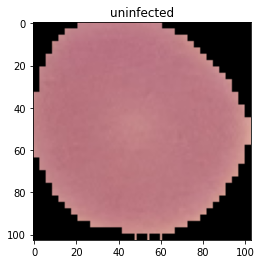

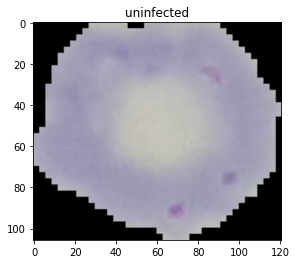

In [12]:
# Show 2 Examples:

get_label_name = metadata.features['label'].int2str

for image, label in train.take(2):
  plt.figure()
  plt.imshow(image)
  plt.title(get_label_name(label))

In [13]:
# Formatting data:

IMG_SIZE = 160

def format_examples(image, label):
  image = tf.cast(image, tf.float32)
  image = (image/127.5) - 1
  image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
  return image, label

In [14]:
# Applying the functions:

train = train.map(format_examples)
validation = val.map(format_examples)
test = test.map(format_examples)

In [15]:
# Shuffle and Batch:

BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 1000

In [16]:
train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
validation_batches = validation.batch(BATCH_SIZE)
test_batches = test.batch(BATCH_SIZE)

In [23]:
for image_batch, label_batch in train_batches.take(1):
   pass

image_batch.shape

TensorShape([32, 160, 160, 3])

In [24]:
# Tranfer Learning time, baby!

IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [25]:
# Freeze all the layers:

base_model.trainable = False

In [26]:
feature_batch = base_model(image_batch)

In [27]:
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 161, 161, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 80, 80, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 80, 80, 32)   128         Conv1[0][0]                      
_______________________________________________________________________________

In [28]:
# Adding classification:

global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)

In [29]:
# Converting values from layer to a single prediction by creating a Dense Layer:

prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)

In [30]:
model = tf.keras.Sequential()

model.add(base_model)
model.add(global_average_layer)
model.add(prediction_layer)

In [31]:
# Compile:

# Learning Rate:
base_lr = 0.0001
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=base_lr),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [32]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_160 (Model) (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_________________________________________________________________


In [34]:
initial_epochs = 10
validation_steps=20

model_history = model.fit(train_batches,
                          epochs=initial_epochs,
                          validation_data=validation_batches)

Epoch 1/10
689/689 [==============================] - 47s 69ms/step - loss: 0.4142 - accuracy: 0.7955 - val_loss: 0.2674 - val_accuracy: 0.8948
Epoch 2/10
689/689 [==============================] - 46s 66ms/step - loss: 0.2407 - accuracy: 0.9156 - val_loss: 0.2237 - val_accuracy: 0.9162
Epoch 3/10
689/689 [==============================] - 46s 67ms/step - loss: 0.2122 - accuracy: 0.9258 - val_loss: 0.2061 - val_accuracy: 0.9198
Epoch 4/10
689/689 [==============================] - 46s 67ms/step - loss: 0.1984 - accuracy: 0.9306 - val_loss: 0.1978 - val_accuracy: 0.9274
Epoch 5/10
689/689 [==============================] - 47s 68ms/step - loss: 0.1898 - accuracy: 0.9344 - val_loss: 0.1900 - val_accuracy: 0.9285
Epoch 6/10
689/689 [==============================] - 47s 68ms/step - loss: 0.1838 - accuracy: 0.9370 - val_loss: 0.1854 - val_accuracy: 0.9314
Epoch 7/10
689/689 [==============================] - 47s 68ms/step - loss: 0.1793 - accuracy: 0.9382 - val_loss: 0.1826 - val_accuracy:

Text(0, 0.5, 'Loss')

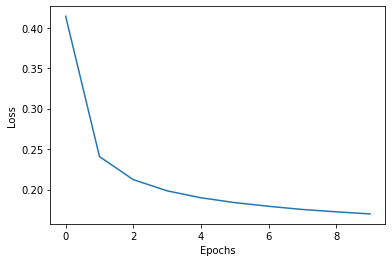

In [35]:
plt.plot(model_history.history['loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')

Text(0, 0.5, 'Loss')

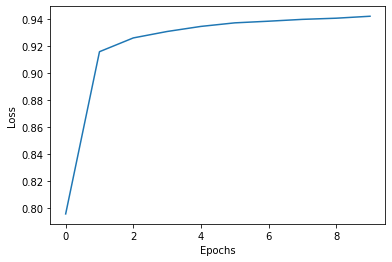

In [36]:
plt.plot(model_history.history['accuracy'])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

Text(0, 0.5, 'Validation Loss')

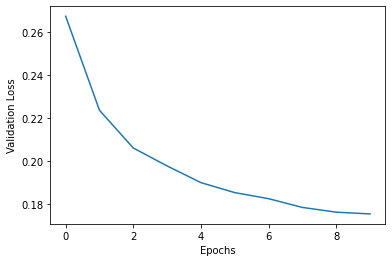

In [39]:
plt.plot(model_history.history['val_loss'])
plt.xlabel('Epochs')
plt.ylabel('Validation Loss')

Text(0, 0.5, 'Validation Accuracy')

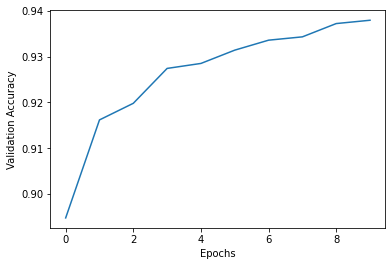

In [40]:
plt.plot(model_history.history['val_accuracy'])
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')